Author: Wonsuk Cha <br>
Date: Feb 14 2022

## Goal of the project

The purpose of this project is to conduct sentiment analysis by creating lexicon approach model from scratch. In this project, we use two set of vocabularies representing positive and negative words, instead of using lexicon based models. <br>

The model has a limit in that it evaluates sentiment by counting positive and negative words not by undersantding the text. However, it is valuable because it shows the initial form of sentiment analysis model.

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import os
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

## Read and explore dataset

Load tweets data in csv file and store it to pandas dataframe. on_bad_lines='skip' prevents a possible error in reading badly formatted rows.
Also, we need to import and keep positive vocabularies and negative vocabularies. These will be stored in type of python list for the convenient use in later process.

In [2]:
# read data csv
FILENAME = 'tweets_data.csv'
df = pd.read_csv(os.path.join(os.getcwd(), FILENAME), on_bad_lines='skip')

# read positive words and negative words
POSITIVE_VOCA_FILE = 'positive_words.csv'
NEGATIVE_VOCA_FILE = 'negative_words.csv'
pos_vocab = list(pd.read_csv(os.path.join(os.getcwd(), POSITIVE_VOCA_FILE))['positive'])
neg_vocab = list(pd.read_csv(os.path.join(os.getcwd(), NEGATIVE_VOCA_FILE))['negative'])

Let's see how dataframe looks like. We can see sentiment, which is our target label, and text we need to analyze.

In [3]:
# check first five rows
df.head(5)

,sentiment,text,user
0,positive,RT @cutedejun: sm not letting xiaojun go for h...,89SHAWDUHJ
1,neutral,@JDaniel2033 He spoke at my Naval boot camp gr...,muhlmannhoss
2,neutral,RT @MdBreathe: Here’s the man to thank for get...,SamArden3
3,negative,RT @mainintrovert: Aww nagtampo puro raw ako #...,Danielle_240702
4,negative,RT @devinisasleep: Lexi bout to be giving that...,jxdanquah


In [4]:
print('Number of tweets: ', df.shape[0])
print('Unique values in sentiment column: ', df['sentiment'].unique())
print('Number of positive tweets: ', df[df['sentiment'] == 'positive'].shape[0])
print('Number of neutral tweets: ', df[df['sentiment'] == 'neutral'].shape[0])
print('Number of negative tweets: ', df[df['sentiment'] == 'negative'].shape[0])

Number of tweets:  99
Unique values in sentiment column:  ['positive' 'neutral' 'negative']
Number of positive tweets:  26
Number of neutral tweets:  60
Number of negative tweets:  13


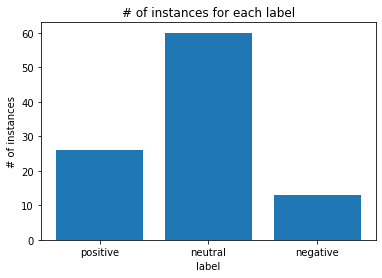

In [5]:
# get labels
labels = df['sentiment'].unique()

# get number of instances for each label
numInstance = []
for label in labels:
    numInstance.append(df[df['sentiment'] == label].shape[0])

# plot a bar chart
plt.bar(labels, numInstance)
plt.title('# of instances for each label')
plt.xlabel('label')
plt.ylabel('# of instances')
plt.show()

## Text Cleaning
As we can see from the dataframe, current text is not prepared to get into analysis immediately. We need to remove some words that our model cannot digest. This can be done with regex and python string methods.

In [6]:
# define clearning function
def tweet_cleaning(text):
    # retweet in the beginning
    text = re.sub(r'(RT\s)?(@\S+)', '', text)
    
    # three dots in the end
    text = re.sub(r'\w*…', '', text)
    
    # website
    text = re.sub(r'http\S+', '', text)
    
    # hashtag
    text = re.sub(r'#+[a-zA-Z0-9(_)]{1,}', '', text)
    
    # new lines
    text = text.replace('\n', '')
    
    # digits and special chars
    text = re.sub(r"[^a-zA-Z' ]", "", text)
    
    return text

df['cleaned'] = df['text'].apply(tweet_cleaning)

After cleaning, now we can see that unncecessary elements in text are all gone.

In [7]:
df.head()

,sentiment,text,user,cleaned
0,positive,RT @cutedejun: sm not letting xiaojun go for h...,89SHAWDUHJ,sm not letting xiaojun go for his graduation ...
1,neutral,@JDaniel2033 He spoke at my Naval boot camp gr...,muhlmannhoss,He spoke at my Naval boot camp graduation Let...
2,neutral,RT @MdBreathe: Here’s the man to thank for get...,SamArden3,Heres the man to thank for getting this march...
3,negative,RT @mainintrovert: Aww nagtampo puro raw ako #...,Danielle_240702,Aww nagtampo puro raw ako Sorry Rui Study t...
4,negative,RT @devinisasleep: Lexi bout to be giving that...,jxdanquah,Lexi bout to be giving that graduation speech...


## Preprocessing

In [8]:
# WordNetLemmatizer instantiate
lemmatizer = WordNetLemmatizer()

# define preprocessing function
def text_preprocessing(text):
    # 1) Lowercase
    text = text.lower()

    # 2) tokenize
    lst_text = word_tokenize(text)
    
    # 3) lemmatize
    lst_lemmatized = [lemmatizer.lemmatize(token) for token in lst_text]

    return lst_lemmatized

# preprocess
df['preprocessed'] = df['cleaned'].apply(text_preprocessing)

In [9]:
df.head()

,sentiment,text,user,cleaned,preprocessed
0,positive,RT @cutedejun: sm not letting xiaojun go for h...,89SHAWDUHJ,sm not letting xiaojun go for his graduation ...,"[sm, not, letting, xiaojun, go, for, his, grad..."
1,neutral,@JDaniel2033 He spoke at my Naval boot camp gr...,muhlmannhoss,He spoke at my Naval boot camp graduation Let...,"[he, spoke, at, my, naval, boot, camp, graduat..."
2,neutral,RT @MdBreathe: Here’s the man to thank for get...,SamArden3,Heres the man to thank for getting this march...,"[here, the, man, to, thank, for, getting, this..."
3,negative,RT @mainintrovert: Aww nagtampo puro raw ako #...,Danielle_240702,Aww nagtampo puro raw ako Sorry Rui Study t...,"[aww, nagtampo, puro, raw, ako, sorry, rui, st..."
4,negative,RT @devinisasleep: Lexi bout to be giving that...,jxdanquah,Lexi bout to be giving that graduation speech...,"[lexi, bout, to, be, giving, that, graduation,..."


## Get sentiment score and predict

There must be a lot of ways for calculating sentiment score. But here we use the following way.<br>
1. Calculate the proportion of positive words.<br>
2. Calculate the proportion of negative words.<br>
3. Subtract the value of 2 from the value of 1.<br>

Theoretically, the score ranges from -1 to 1.

In [10]:
# define a function for sentiment score calculation
def get_sentiment_score(tokens):
    
    # length of tokens
    token_len = len(tokens)
    
    # proportion of positive & negative words
    pos_counter = 0
    neg_counter = 0
    for token in tokens:
        if token in pos_vocab: pos_counter += 1
        if token in neg_vocab: neg_counter += 1
            
    pos_rate = pos_counter / token_len
    neg_rate = neg_counter / token_len
    
    # return sentiment score
    return pos_rate - neg_rate

# calculate score
df['score'] = df['preprocessed'].apply(get_sentiment_score)

Now that we got the sentiment score of each tweet, let's compare the distribution of scores with actual labels.

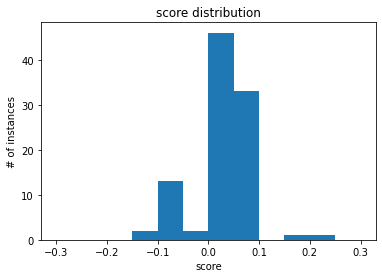

In [11]:
# bins that will be used for histogram
bins = [-0.3, -0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]

# plot
plt.hist(df['score'], bins)
plt.title('score distribution')
plt.ylabel('# of instances')
plt.xlabel('score')
plt.show()

To assign each record to one of sentiment classes, we need to draw lines to classify. I applied the following rules.<br>
1. score < 0: negative
2. score == 0: neutral
3. score > 0: positive

In [12]:
# define sentiment classifier
def sentiment_classifier(score):
    if score < 0:
        return 'negative'
    elif score == 0.0:
        return 'neutral'
    else:
        return 'positive'

# prediction
df['sentiment_pred'] = df['score'].apply(sentiment_classifier)

## Evaluate the model

It's the moment of truth. Let's evaluate the model's prediction based on the given label

In [13]:
# create list of predicted and actual
y_pred = list(df['sentiment_pred'])
y_actual = list(df['sentiment'])

# get accuracy and f1 score
accuracy = accuracy_score(y_actual, y_pred)
f1 = f1_score(y_actual, y_pred, average='macro')

# print out the results
print(f'Accuracy: {accuracy}')
print(f'f1 score: {f1}')

Accuracy: 0.45454545454545453
f1 score: 0.43934943158244133


We've got 0.45 of accuracy and 0.44 of f1 score, which is not very satisfactory. However, it is always a good way to start a journey by implementing a heuristic model and setting a baseline. We could get better accuracy if we use more sophisticated way such as deep learning.